In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\competitive-data-science-predict-future-sales\items-translated.csv
../input\competitive-data-science-predict-future-sales\items.csv
../input\competitive-data-science-predict-future-sales\item_categories-translated.csv
../input\competitive-data-science-predict-future-sales\item_categories.csv
../input\competitive-data-science-predict-future-sales\sales_train.csv
../input\competitive-data-science-predict-future-sales\sample_submission.csv
../input\competitive-data-science-predict-future-sales\shops-translated.csv
../input\competitive-data-science-predict-future-sales\shops.csv
../input\competitive-data-science-predict-future-sales\test.csv


In [3]:
pd.set_option('display.max_columns', None)

import pprint as pp
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso, LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor

from scipy import stats
from scipy.special import boxcox1p

%matplotlib inline

In [ ]:
a = [1, 2, 3]
a[-1:-1:-1]

In [4]:
preprocessedTrainDataFp = r'../input\competitive-data-science-predict-future-sales\preprocessedTrainData.csv'

In [5]:
trainCsvFilepath = r'../input\competitive-data-science-predict-future-sales\sales_train.csv'

testCsvFilepath = r'../input\competitive-data-science-predict-future-sales\test.csv'
rawTestDf = pd.read_csv(testCsvFilepath)

shopsCsvFilepath = r'../input\competitive-data-science-predict-future-sales\shops.csv'
shopsDf = pd.read_csv(shopsCsvFilepath)

itemsCsvFilepath = r'../input\competitive-data-science-predict-future-sales\items.csv'
itemsDf = pd.read_csv(itemsCsvFilepath)

In [21]:
if os.path.exists(preprocessedTrainDataFp):
    rawTrainDf = pd.read_csv(preprocessedTrainDataFp)
else:
    rawTrainDf = pd.read_csv(trainCsvFilepath)
    
    # Create columns for day, month, and year
    # loop is faster and memory efficient compared to apply
    # https://ys-l.github.io/posts/2015/08/28/how-not-to-use-pandas-apply/
    days, months, years = [], [], []
    for _, row in rawTrainDf.iterrows():
        day, month, year = [int(x) for x in row.date.split('.')]
        days.append(day)
        months.append(month)
        years.append(year)
        
    temp = pd.concat([rawTrainDf,
                     pd.DataFrame({
                         'day':days,
                         'month':months,
                         'year':years
                     })], axis=1, )
    temp.to_csv(preprocessedTrainDataFp, index=False)
    rawTrainDf = temp

# Replace Russian text with English translation

### Thanks to https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/54949

In [23]:
itemNamesTranslationFp = r'../input\competitive-data-science-predict-future-sales\items-translated.csv'

itemCatsTranslationFp = r'../input\competitive-data-science-predict-future-sales\item_categories-translated.csv'

shopNamesTranslationFp = r'../input\competitive-data-science-predict-future-sales\shops-translated.csv'

In [24]:
if (os.path.exists(itemNamesTranslationFp) and os.path.exists(itemCatsTranslationFp) and os.path.exists(shopNamesTranslationFp)):
    itemNamesTranslationDf = pd.read_csv(itemNamesTranslationFp)
    itemCatsTranslationDf = pd.read_csv(itemCatsTranslationFp)
    shopNamesTranslationDf = pd.read_csv(shopNamesTranslationFp)

    assert shopsDf.shape == shopNamesTranslationDf.shape
    assert len(shopsDf.shop_id.unique()) == len(shopNamesTranslationDf.shop_id.unique())
    assert np.all(shopNamesTranslationDf.shop_id == shopsDf.shop_id)

    shopsDf.shop_name = shopNamesTranslationDf.shop_name_translated

    assert len(itemsDf.item_id.unique()) == len(itemNamesTranslationDf.item_id.unique())
    assert pd.isna(itemNamesTranslationDf.item_name_translated).sum() == 0

    temp = itemsDf.join(itemNamesTranslationDf, on='item_id', rsuffix='_translated')
    itemsDf.item_name = temp.item_name_translated

    temp = itemsDf.join(itemCatsTranslationDf, on='item_category_id', rsuffix='_translated', how='left')
    temp.drop(columns=['item_category_id_translated'], inplace=True)
    temp.rename(columns={'item_category_name_translated':'item_category_name'}, inplace=True)
    itemsDf = temp

In [25]:
print(rawTrainDf.shape)
print(rawTestDf.shape)
print(shopsDf.shape)
print(itemsDf.shape)

(2935849, 9)
(214200, 3)
(60, 2)
(22170, 5)


In [26]:
display(rawTrainDf.head())
display(rawTestDf.head())
display(shopsDf.head())
display(itemsDf.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,2,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,3,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,5,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,6,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,1,2013


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,shop_name,shop_id
0,"Yakutsk Ordzhonikidze, 56 francs",0
1,"Yakutsk TC ""Central"" franc",1
2,"Adygea Shopping Center ""Mega""",2
3,"Balashikha TRK ""October-Kinomir""",3
4,"Volzhsky shopping center ""Volga Mall""",4


,item_name,item_id,item_category_id,item_category_name,item_category_name
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40,Cinema - DVD,Cinema - DVD
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76,Programs - Home and Office (Figure),Programs - Home and Office (Figure)
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40,Cinema - DVD,Cinema - DVD
3,*** BLUE WAVE (Univ) D,3,40,Cinema - DVD,Cinema - DVD
4,*** BOX (GLASS) D,4,40,Cinema - DVD,Cinema - DVD


In [27]:
print(rawTestDf.isna().sum().sum())
print(rawTrainDf.isna().sum().sum())

0
0


# Item table

In [28]:
display(itemsDf.head())

,item_name,item_id,item_category_id,item_category_name,item_category_name
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40,Cinema - DVD,Cinema - DVD
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76,Programs - Home and Office (Figure),Programs - Home and Office (Figure)
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40,Cinema - DVD,Cinema - DVD
3,*** BLUE WAVE (Univ) D,3,40,Cinema - DVD,Cinema - DVD
4,*** BOX (GLASS) D,4,40,Cinema - DVD,Cinema - DVD


# Join tables

In [29]:
joinedTrainDf = rawTrainDf.join(itemsDf, on=['item_id'], rsuffix='r', ).join(shopsDf, on=['shop_id'], rsuffix='r').drop(columns=['item_idr', 'shop_idr'])
display(joinedTrainDf.head())
print(joinedTrainDf.isna().sum().sum())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_name,item_category_id,item_category_name,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,2,1,2013,SCENE 2012 (BD),37,Cinema - Blu-Ray,Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair"""
1,03.01.2013,0,25,2552,899.00,1.0,3,1,2013,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,Music - Vinyl,"Moscow TRK ""Atrium"""
2,05.01.2013,0,25,2552,899.00,-1.0,5,1,2013,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,Music - Vinyl,"Moscow TRK ""Atrium"""
3,06.01.2013,0,25,2554,1709.05,1.0,6,1,2013,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,Music - Vinyl,"Moscow TRK ""Atrium"""
4,15.01.2013,0,25,2555,1099.00,1.0,15,1,2013,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of branded production,Music - CD of branded production,"Moscow TRK ""Atrium"""


0


In [30]:
display(joinedTrainDf.describe())

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,1.585267e+01,6.247717e+00,2.013777e+03,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,8.923483e+00,3.536219e+00,7.684790e-01,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,1.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,8.000000e+00,3.000000e+00,2.013000e+03,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,1.600000e+01,6.000000e+00,2.014000e+03,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.400000e+01,9.000000e+00,2.014000e+03,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,3.100000e+01,1.200000e+01,2.015000e+03,8.300000e+01


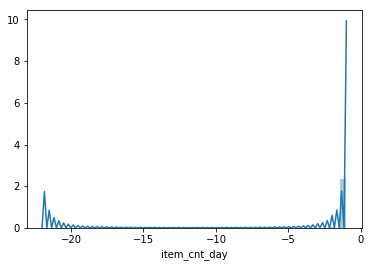

In [31]:
sns.distplot(joinedTrainDf[joinedTrainDf.item_cnt_day < 0].item_cnt_day)

In [32]:
joinedTrainDf[joinedTrainDf.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_name,item_category_id,item_category_name,item_category_name,shop_name
484683,15.05.2013,4,32,2973,-1.0,1.0,15,5,2013,"DmC Devil May Cry [PS3, Russian subtitles]",19,Games - PS3,Games - PS3,"Moscow Shopping Center ""Silver House"""


## Check if item price changes for same item_id

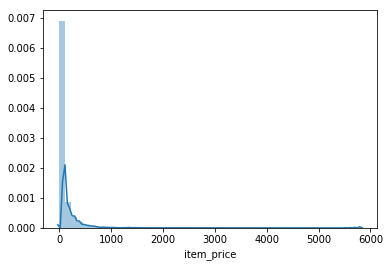

In [33]:
pricesGroupBy_item_id = joinedTrainDf.groupby(by=['item_id']).item_price.std().dropna()
sns.distplot(pricesGroupBy_item_id)

# Date range

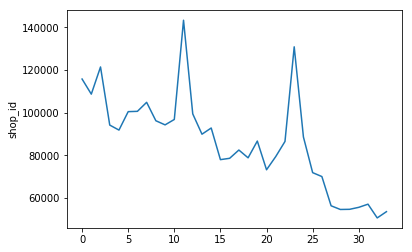

In [36]:
# By entry count

temp = rawTrainDf.groupby(by=['year', 'month']).shop_id.count()
sns.lineplot(y=temp, x=[x for x in range(len(temp))])

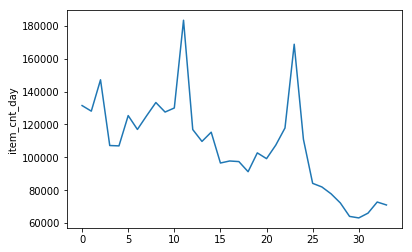

In [37]:
# By sum of number of sold items

temp = rawTrainDf.groupby(by=['year', 'month']).item_cnt_day.sum()
sns.lineplot(y=temp, x=[x for x in range(len(temp))])

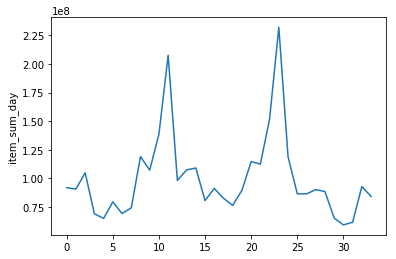

In [44]:
# By sum of value of sold items

copy = rawTrainDf.copy()

copy['item_sum_day'] = copy.item_cnt_day * copy.item_price

temp = copy.groupby(by=['year', 'month']).item_sum_day.sum()
sns.lineplot(y=temp, x=[x for x in range(len(temp))])

# Review test data

In [13]:
display(rawTestDf.head())

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [19]:
shopId_itemId = rawTestDf.shop_id.astype(str) + '-' + rawTestDf.item_id.astype(str)
shopId_itemId.value_counts().describe()

count    214200.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

All shop+item combos are unique

In [46]:
a = 'asb'
a[3:]

''